Сделаем преобработку файлов, выделив валидационную выборку. Оценим количество изображений по классам и их размер.

In [1]:
import os
import shutil
import random

import pandas as pd
import seaborn as sns

from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

In [2]:
random.seed(0)

FILE_NAME = 'FORLEARNFULL022022.zip'
FILE_PATH = os.getcwd()

In [3]:
if not os.path.exists(FILE_PATH + '/dataset'):
    # распаковываем архив
    shutil.unpack_archive(FILE_NAME, FILE_PATH)

    # переименовываем папку
    os.rename('FORLEARNFULL', 'dataset')

    # создаем папку для валидационной выборки
    os.makedirs(FILE_PATH + '/dataset/to_val')

    # перемещаем до 10% изображений из тренировочного сета в валидацонный
    for dir in os.listdir(FILE_PATH + '/dataset/to_train'):
        os.makedirs(FILE_PATH + '/dataset/to_val/' + dir)

        files = os.listdir(FILE_PATH + f'/dataset/to_train/{dir}')
        files_to_copy_count = len(files)//10
        files_to_copy = []

        for _ in range(files_to_copy_count):
            files_to_copy.append(random.choice(files))
        
        # удаляем битые файлы, которые выкидывают ошибку при открытии
        for file in files_to_copy:
            copy_from = FILE_PATH + f'/dataset/to_train/{dir}/{file}'
            copy_to = FILE_PATH + f'/dataset/to_val/{dir}/{file}'
            try:
                shutil.copyfile(copy_from, copy_to)
            except FileNotFoundError:
                pass

            try:
                os.remove(copy_from)
            except FileNotFoundError:
                pass

# почистим картинки от битых файлов
# вместе с тем узнаем размер изображений
counter = 0
min_width = float('inf')
max_width = 0
min_height = float('inf')
max_height = 0

files = Path(FILE_PATH + '/dataset').rglob("*.jpg")
for file in tqdm(files):
    try:
        img = Image.open(file)
    except UnidentifiedImageError:
        counter += 1
        os.remove(file)
    
    width, height = img.size
    min_width = min(min_width, width)
    max_width = max(max_width, width)
    min_height = min(min_height, height)
    max_height = max(max_height, height)

print(f'Удалено {counter} битых избражений')
print(f'Ширина изображений лежит в диапазоне от {min_width} до {max_width}')
print(f'Высота изображений лежит в диапазоне от {min_height} до {max_height}')

108593it [16:05, 112.44it/s]

Удалено 0 битых избражений
Ширина изображений лежит в диапазоне от 224 до 224
Высота изображений лежит в диапазоне от 126 до 126


Создадим датафрейм с именами изоражений.

In [4]:
files = Path(FILE_PATH + '/dataset').rglob("*.jpg")
df = pd.DataFrame(data={'path': list(files)})

In [5]:
df['filename'] = df['path'].apply(lambda x: os.path.basename(x))
df['category'] = df['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df['set'] = df['path'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))))
df.drop('path', axis=1, inplace=True)

In [6]:
df.head()

,filename,category,set
0,12496175_b29025_c1757_user_652_T.jpg,01,to_test
1,13690341_b235_c1781_user_1_T.jpg,01,to_test
2,17874100_b245_c347_user_649_T.jpg,01,to_test
3,18685576_b66316_c2361_user_652_T.jpg,01,to_test
4,20490681_b15835_c1453_user_652_T.jpg,01,to_test


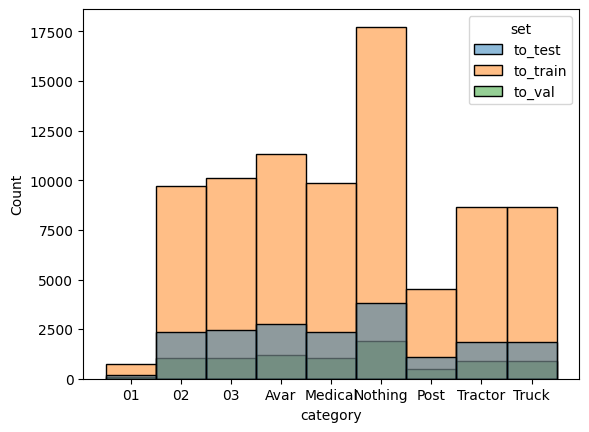

In [7]:
sns.histplot(data=df, x='category', hue='set');

In [8]:
df.groupby(['category']).aggregate({'filename': 'count'}) / len(df)

,filename
category,
01,0.008978
02,0.120846
03,0.125726
Avar,0.140562
Medical,0.122144
Nothing,0.215741
Post,0.055924
Tractor,0.104694
Truck,0.105384


In [9]:
df.groupby(['set']).aggregate({'filename': 'count'}) / len(df)

,filename
set,
to_test,0.172111
to_train,0.749045
to_val,0.078845


In [13]:
img = None

# Упакуем новый архив и удалим папку.
if not os.path.exists(FILE_PATH + '/dataset.zip'):
    shutil.make_archive(FILE_PATH + '/dataset', 'zip', FILE_PATH + '/dataset')

if os.path.exists(FILE_PATH + '/dataset'):
    shutil.rmtree(FILE_PATH + '/dataset')